In [33]:
import torch
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics.functional import multiclass_accuracy
import seaborn as sns
import matplotlib.pyplot as plt
import random

Setting up file paths and some other things for converting image data to tensors.

In [2]:
training_path ='./archive/Train Images 13440x32x32/train/'
test_path ='./archive/Test Images 3360x32x32/test/'


train_files=os.listdir(training_path)
test_files=os.listdir(test_path)
transform=transforms.Compose([transforms.ToTensor()])


In [3]:
def data_builder(path, files):
    '''Function for converting image data to tensors for using in training, along with getting the labels
       from the file name.
    '''
    img_fordim=cv2.imread(os.path.join(path,files[0]), 0)
    image_size=torch.flatten(transform(img_fordim))
    dim1=image_size.shape[0]
    dim0=len(files)
    data=torch.zeros((dim0, dim1))
    labels=torch.zeros((dim0, 1))
    for i, file in enumerate(files):
        img=cv2.imread(os.path.join(path,file), 0)
        flat_tens=torch.flatten(transform(img))
        data[i]=flat_tens
        label=file.split('_')[-1][:2]
        labels[i]=float(label)-1
        
    return data, labels

In [4]:
device= 'cuda' if torch.cuda.is_available() else "cpu"

device

'cpu'

In [5]:
test_data, test_labels = data_builder(test_path, test_files)

train_data, train_labels = data_builder(training_path, train_files)


In [56]:
torch.save(test_data, 'test_data.pt')
torch.save(test_labels, 'test_labels.pt')
torch.save(train_data, 'train_data.pt')
torch.save(train_labels, 'train_labels.pt')

In [6]:
class ArabicCharClassifier(nn.Module):
    def __init__(self, n_char):
        super().__init__()
        self.hidden1=nn.Linear(1024, 100)
        self.hidden2=nn.Linear(100, 100)
        self.hidden3=nn.Linear(100,100)
        self.hidden4=nn.Linear(100,100)
        self.hidden5=nn.Linear(100,100)
        self.hiddenfin=nn.Linear(100, n_char)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout()
        self.batch1=nn.BatchNorm1d(100)
        self.batch2=nn.BatchNorm1d(100)
        self.batch3=nn.BatchNorm1d(100)
        self.batch4=nn.BatchNorm1d(100)
        self.batch5=nn.BatchNorm1d(100)
        
    def forward(self, x):
        X = self.hidden1(x)
        X = self.relu(X)
        X = self.batch1(X)
        X = self.dropout(X)
        
        X = self.hidden2(X)
        X = self.relu(X)
        X = self.batch2(X)
        X = self.dropout(X)
        
        X = self.hidden3(X)
        X = self.relu(X)
        X = self.batch3(X)
        X = self.dropout(X)
        
        X = self.hidden4(X)
        X = self.relu(X)
        X = self.batch4(X)
        X = self.dropout(X)
        
        X = self.hidden5(X)
        X = self.relu(X)
        X = self.batch5(X)
        X = self.dropout(X)
        
        
        
        X = self.hiddenfin(X)
        
        return X
    

In [7]:
model=ArabicCharClassifier(n_char=28).to(device)
model

ArabicCharClassifier(
  (hidden1): Linear(in_features=1024, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=100, bias=True)
  (hidden4): Linear(in_features=100, out_features=100, bias=True)
  (hidden5): Linear(in_features=100, out_features=100, bias=True)
  (hiddenfin): Linear(in_features=100, out_features=28, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batch1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [8]:
loss = nn.CrossEntropyLoss()

optimization = optim.Adam(params=model.parameters(), lr=0.001)

In [9]:
def metrics(y_pred, y_true, num_char):
    acc = multiclass_accuracy(y_pred, y_true)
    f1_score = multiclass_f1_score(y_pred, y_true, num_classes=num_char)
    return f1_score, acc 

In [10]:
num_epoch = 200

train_data, train_labels = train_data.to(device), train_labels.to(device)

test_data, test_labels = test_data.to(device), test_labels.to(device)

train_metrics={'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

test_metrics = {'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

for epoch in range(num_epoch):
    
    train_pred=model(train_data)
    model.train()
    
    
    
    y_train = torch.squeeze(train_labels).type(torch.LongTensor) 
    
    optimization.zero_grad()
    
    loss_epoch = loss(train_pred, y_train)
    
    f1_train, acc_train = metrics(train_pred, y_train, 28)
    
    loss_epoch.backward()
    
    optimization.step()
    
    train_metrics['loss'].append(loss_epoch.item())
    train_metrics['accuracy'].append(acc_train.item()*100)
    train_metrics['f1_score'].append(f1_train.item())
    
    model.eval()
    with torch.inference_mode():
        test_pred = model(test_data)
        y_eval = torch.squeeze(test_labels).type(torch.LongTensor) 
        loss_eval=loss(test_pred, y_eval)
        f1_test, acc_test = metrics(test_pred, torch.squeeze(test_labels), 28)
        
        test_metrics['accuracy'].append(acc_test.item()*100)
        test_metrics['f1_score'].append(f1_test.item())
        test_metrics['loss'].append(loss_eval.item())
        
        
    if epoch%10==0:
        print(f'Epoch: {epoch} | Train loss: {loss_epoch:.5f} | Train accuracy: {acc_train*100:.3f}% | Train f1 {f1_train:.3f} | Test accuracy {acc_test*100:.3f}% | Test f1 {f1_test:.3f}')
        
        
    

Epoch: 0 | Train loss: 3.64988 | Train accuracy: 3.683% | Train f1 0.037 | Test accuracy 3.571% | Test f1 0.036
Epoch: 10 | Train loss: 3.33180 | Train accuracy: 3.713% | Train f1 0.037 | Test accuracy 3.780% | Test f1 0.038
Epoch: 20 | Train loss: 3.32858 | Train accuracy: 7.932% | Train f1 0.079 | Test accuracy 7.321% | Test f1 0.073
Epoch: 30 | Train loss: 3.31305 | Train accuracy: 7.604% | Train f1 0.076 | Test accuracy 8.393% | Test f1 0.084
Epoch: 40 | Train loss: 3.20783 | Train accuracy: 6.749% | Train f1 0.067 | Test accuracy 6.399% | Test f1 0.064
Epoch: 50 | Train loss: 2.95550 | Train accuracy: 9.583% | Train f1 0.096 | Test accuracy 10.744% | Test f1 0.107
Epoch: 60 | Train loss: 2.78045 | Train accuracy: 12.344% | Train f1 0.123 | Test accuracy 11.518% | Test f1 0.115
Epoch: 70 | Train loss: 2.57420 | Train accuracy: 19.256% | Train f1 0.193 | Test accuracy 18.274% | Test f1 0.183
Epoch: 80 | Train loss: 2.34308 | Train accuracy: 25.432% | Train f1 0.254 | Test accuracy 2

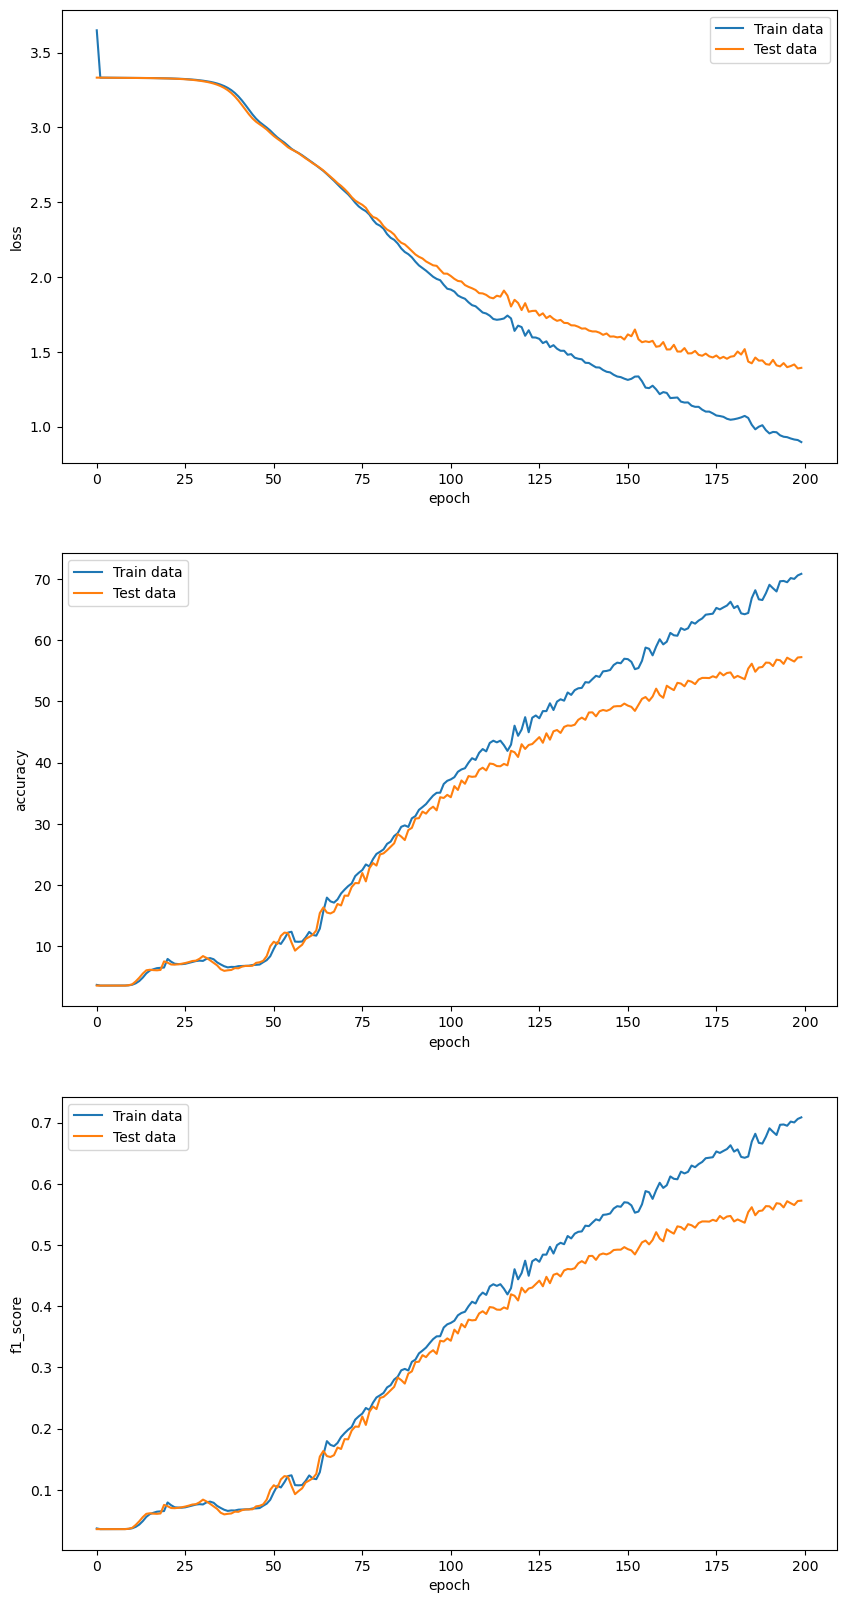

In [11]:
fig, axs = plt.subplots(3, figsize=(10,20))
sns.lineplot(data=train_metrics, x='epoch', y='loss', label='Train data', ax=axs[0])
sns.lineplot(data=test_metrics, x='epoch', y='loss', label='Test data', ax=axs[0])
sns.lineplot(data=train_metrics, x='epoch', y='accuracy', label='Train data', ax=axs[1])
sns.lineplot(data=test_metrics, x='epoch', y='accuracy', label='Test data', ax=axs[1])
sns.lineplot(data=train_metrics, x='epoch', y='f1_score', label='Train data', ax=axs[2])
sns.lineplot(data=test_metrics, x='epoch', y='f1_score', label='Test data', ax=axs[2])
plt.legend()

In [45]:
class ModularNN(nn.Module):
    def __init__(self, n_char, input_size, neurons, depth, add_Dropout=True):
        super().__init__()
        self.layers=nn.ModuleList()
        self.input_layer=nn.Linear(input_size, neurons)
        for i in range(depth):
            self.layers.append(nn.Linear(neurons, neurons))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(neurons))
            if add_Dropout:
                self.layers.append(nn.Dropout())
        self.final_layer=nn.Linear(neurons, n_char)

    def forward(self, X):
        x=self.input_layer(X)
        for layer in self.layers:
            x=layer(x)
        x=self.final_layer(x)
        
        return x
            

In [46]:
model_2=ModularNN(n_char=28, input_size=1024, neurons=100, depth=5).to(device)
model_2

ModularNN(
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=100, out_features=100, bias=True)
    (17): ReLU()
    (18): BatchNorm1d(100, eps=1e-05, momentum=0.1,

In [49]:
def SingleTrain(layer_size, depth, num_epochs, learning_rate, printing = False, train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, loss=nn.CrossEntropyLoss()):
    model=model_2=ModularNN(n_char=28, input_size=1024, neurons=layer_size, depth=depth).to(device)
    loss=loss
    optimization= optim.Adam(params=model.parameters(), lr=learning_rate)

    train_metrics={'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

    test_metrics = {'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

    for epoch in range(num_epochs):
    
        train_pred=model(train_data)
        model.train()
        
        y_train = torch.squeeze(train_labels).type(torch.LongTensor) 
        
        optimization.zero_grad()
        
        loss_epoch = loss(train_pred, y_train)
        
        f1_train, acc_train = metrics(train_pred, y_train, 28)
        
        loss_epoch.backward()
        
        optimization.step()
        
        train_metrics['loss'].append(loss_epoch.item())
        train_metrics['accuracy'].append(acc_train.item()*100)
        train_metrics['f1_score'].append(f1_train.item())
    
        model.eval()
        with torch.inference_mode():
            test_pred = model(test_data)
            y_eval = torch.squeeze(test_labels).type(torch.LongTensor) 
            loss_eval=loss(test_pred, y_eval)
            f1_test, acc_test = metrics(test_pred, torch.squeeze(test_labels), 28)
            
            test_metrics['accuracy'].append(acc_test.item()*100)
            test_metrics['f1_score'].append(f1_test.item())
            test_metrics['loss'].append(loss_eval.item())

        if printing:
            if epoch%10==0:
                print(f'Epoch: {epoch} | Train loss: {loss_epoch:.5f} | Train accuracy: {acc_train*100:.3f}% | Train f1 {f1_train:.3f} | Test accuracy {acc_test*100:.3f}% | Test f1 {f1_test:.3f}')
            

    return train_metrics, test_metrics

    

In [71]:
depths=[2,3,4,5,6,7,8,9,10]
layer_sizes=[30, 40, 50, 60, 70, 80, 90, 100, 110]

ran_depths = random.choices(depths, k=10)
ran_sizes = random.choices(layer_sizes, k=10)

In [73]:
training_data=[]
testing_data=[]
parameters={'rate':[], 'depth':[], 'size':[]}
k=0
for depth, size in zip(ran_depths, ran_sizes):
    print(depth, size)
    tr_metric, ts_metric = SingleTrain(layer_size=size, depth=depth, num_epochs=200, learning_rate=0.001, printing=True)
    training_data.append(tr_metric)
    testing_data.append(ts_metric)
    parameters['rate'].append(rate)
    parameters['depth'].append(depth)
    parameters['size'].append(size)
    k+=1
    print(f'{k} down, {10-k} to go')

5 80
Epoch: 0 | Train loss: 3.61121 | Train accuracy: 3.832% | Train f1 0.038 | Test accuracy 3.571% | Test f1 0.036
Epoch: 10 | Train loss: 3.33293 | Train accuracy: 3.683% | Train f1 0.037 | Test accuracy 3.958% | Test f1 0.040
Epoch: 20 | Train loss: 3.33072 | Train accuracy: 5.729% | Train f1 0.057 | Test accuracy 5.714% | Test f1 0.057
Epoch: 30 | Train loss: 3.32543 | Train accuracy: 8.943% | Train f1 0.089 | Test accuracy 9.315% | Test f1 0.093
Epoch: 40 | Train loss: 3.30039 | Train accuracy: 10.015% | Train f1 0.100 | Test accuracy 9.405% | Test f1 0.094
Epoch: 50 | Train loss: 3.11564 | Train accuracy: 6.488% | Train f1 0.065 | Test accuracy 6.667% | Test f1 0.067
Epoch: 60 | Train loss: 2.84076 | Train accuracy: 13.125% | Train f1 0.131 | Test accuracy 12.649% | Test f1 0.126
Epoch: 70 | Train loss: 2.62794 | Train accuracy: 17.582% | Train f1 0.176 | Test accuracy 18.214% | Test f1 0.182
Epoch: 80 | Train loss: 2.44951 | Train accuracy: 22.031% | Train f1 0.220 | Test accur